In [1]:
import qiskit

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister



from qiskit import IBMQ
from qiskit import Aer,BasicAer, execute, assemble
from qiskit.providers.aer import AerSimulator

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error,phase_damping_error
from qiskit.quantum_info.operators import Operator


# Needed for functions
import time
from copy import deepcopy
import numpy as np
from numpy import pi

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.visualization import plot_bloch_multivector

import qiskit.quantum_info as qi
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import partial_trace, Statevector

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

from qiskit.circuit.gate import Gate
from qiskit.extensions import UGate

C:\Users\dimav\AppData\Local\Temp\ipykernel_10988\3305212117.py:35: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [ ]:
def ChannelFromChoi( choi_mat, dens_mat):
    if type(dens_mat) == list or type(dens_mat) == np.ndarray:
        dens_mat = qi.DensityMatrix(dens_mat)
    tr_dens = dens_mat.to_operator().transpose()
    mat = choi_mat.dot(tr_dens)
    chan = (partial_trace(mat.data,[1])).data
    return chan

In [ ]:
class Channel_proc:
    def __init__(self, choi):
        self.choi = choi
    def outvec(self, in_vec):
        expected = ChannelFromChoi(self.choi,in_vec)
#         print(expected.trace())
        expected = expected/expected.trace()
#         plot_bloch_multivector(expected)
        expected = qi.DensityMatrix(expected)
        return expected

In [ ]:
# for curcuit and beckend return chennel ( works only for teleoprtation-like systems)
def ChannelFromProc ( backend, circuit , noise_model=None, measured = 1, prepeared = 0, input_job = None):
    
    qpt_circs = process_tomography_circuits(circuit, [measured], prepared_qubits=[prepeared])
    if input_job == None:
        job = qiskit.execute(qpt_circs, backend, shots=4000,noise_model=noise_model)
    else :
        job = input_job
    # Extract tomography data so that counts are indexed by measurement configuration
    qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
    print(qpt_tomo.data)
    
    # Tomographic reconstruction

    t = time.time()
    choi_fit = qpt_tomo.fit(method='lstsq')
    print('Fit time:', time.time() - t)
    print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit)))

#     expected = ChannelFromChoi(choi_fit,[1/np.sqrt(2),-1/np.sqrt(2)])
#     print(expected)
#     plot_bloch_multivector(expected)
    chan = Channel_proc(choi_fit)
    return chan, job

In [ ]:
def Final_State_Tomography (backend, circuit , noise_model=None, measured = 1, prepeared = 0, input_job = None):
    # Generate circuits and run on simulator
#     t = time.time()

    # Generate the state tomography circuits.
    qst_circuit = state_tomography_circuits(circuit, [measured])

    # Execute
    job = qiskit.execute(qst_circuit, backend = backend ,noise_model=noise_model, shots=5000)
#     print('Time taken:', time.time() - t)

    # Fit result
    circ_fitter_teleport = StateTomographyFitter(job.result(), qst_circuit)

    # Perform the tomography fit
    # which outputs a density matrix
    rho_fit_telep = circ_fitter_teleport.fit(method='lstsq')
    rho = qi.DensityMatrix(rho_fit_telep)
    plot_bloch_multivector(rho.data)
    return rho, job

In [ ]:
%matplotlib inline
def TransSphereFromChannel ( channel,in_States=None, noise_model=None, measured=4):

    # Create a sphere
    u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:16j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
   
    
    if in_States==None :
        xx = np.copy(x)
        yy = np.copy(y)
        zz = np.copy(z)
        for i in range(len(z)):
            for j in range(len(z[0])):
                in_state = qi.Pauli('I').to_matrix()/2 + qi.Pauli('X').to_matrix()*x[i,j]/2 + qi.Pauli('Y').to_matrix()*y[i,j]/2 + qi.Pauli('Z').to_matrix()*z[i,j]/2
                sub_rho = channel.outvec(in_state)
#                 sub_rho = qi.DensityMatrix(in_state)
                xx[i,j]=(qi.Pauli('X').to_matrix().dot(sub_rho)).trace().real
                yy[i,j]=(qi.Pauli('Y').to_matrix().dot(sub_rho)).trace().real
                zz[i,j]=(qi.Pauli('Z').to_matrix().dot(sub_rho)).trace().real
    else :
        xx,yy,zz = np.array([]),np.array([]),np.array([])
        in_x, in_y, in_z = [],[],[]
        for in_state in in_States :
            sub_rho = channel.outvec(in_state)
#             sub_rho = qi.DensityMatrix(in_state)
            xx=np.append(xx, (qi.Pauli('X').to_matrix().dot(sub_rho)).trace().real)
            yy=np.append(yy,(qi.Pauli('Y').to_matrix().dot(sub_rho)).trace().real)
            zz=np.append(zz, (qi.Pauli('Z').to_matrix().dot(sub_rho)).trace().real)
            
            in_x, in_y, in_z = np.append(in_x,(qi.Pauli('X').to_matrix().dot(qi.DensityMatrix(in_state))).trace().real),\
            np.append(in_y,(qi.Pauli('Y').to_matrix().dot(qi.DensityMatrix(in_state))).trace().real),\
            np.append(in_z,(qi.Pauli('Z').to_matrix().dot(qi.DensityMatrix(in_state))).trace().real)
  
#    Set colours and render
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     ax.plot_wireframe(xx, yy, zz, color="k", rstride=1, cstride=2,linewidth=1)
    ax.scatter(xx,yy,zz,color="k",s=1)
#     ax.plot( xx, yy, zz, color='c', alpha=0.3, linewidth=1)
    if in_States != None:
        ax.scatter(in_x,in_y,in_z,color="b",s=1)
    else :
        ax.plot_wireframe(x, y, z, color="r", rstride=1, cstride=2,linewidth=1)
        ax.plot_wireframe(xx, yy, zz, color="k", rstride=1, cstride=2,linewidth=1)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    # ax.set_aspect("equal")
    plt.tight_layout()
   
    plt.show()

In [ ]:
def prepStates( theta,phi) :
    phi_arr = np.linspace(-np.pi,np.pi,num=theta)
    a_arr = np.linspace(0,np.pi,num=phi)
    test_states = [] 
    for a_i in a_arr:
        for phi_i in np.exp(1j*phi_arr):
            test_states.append( [phi_i*np.cos(a_i),np.sin(a_i)] )
    return     test_states

In [ ]:
# define your provider below


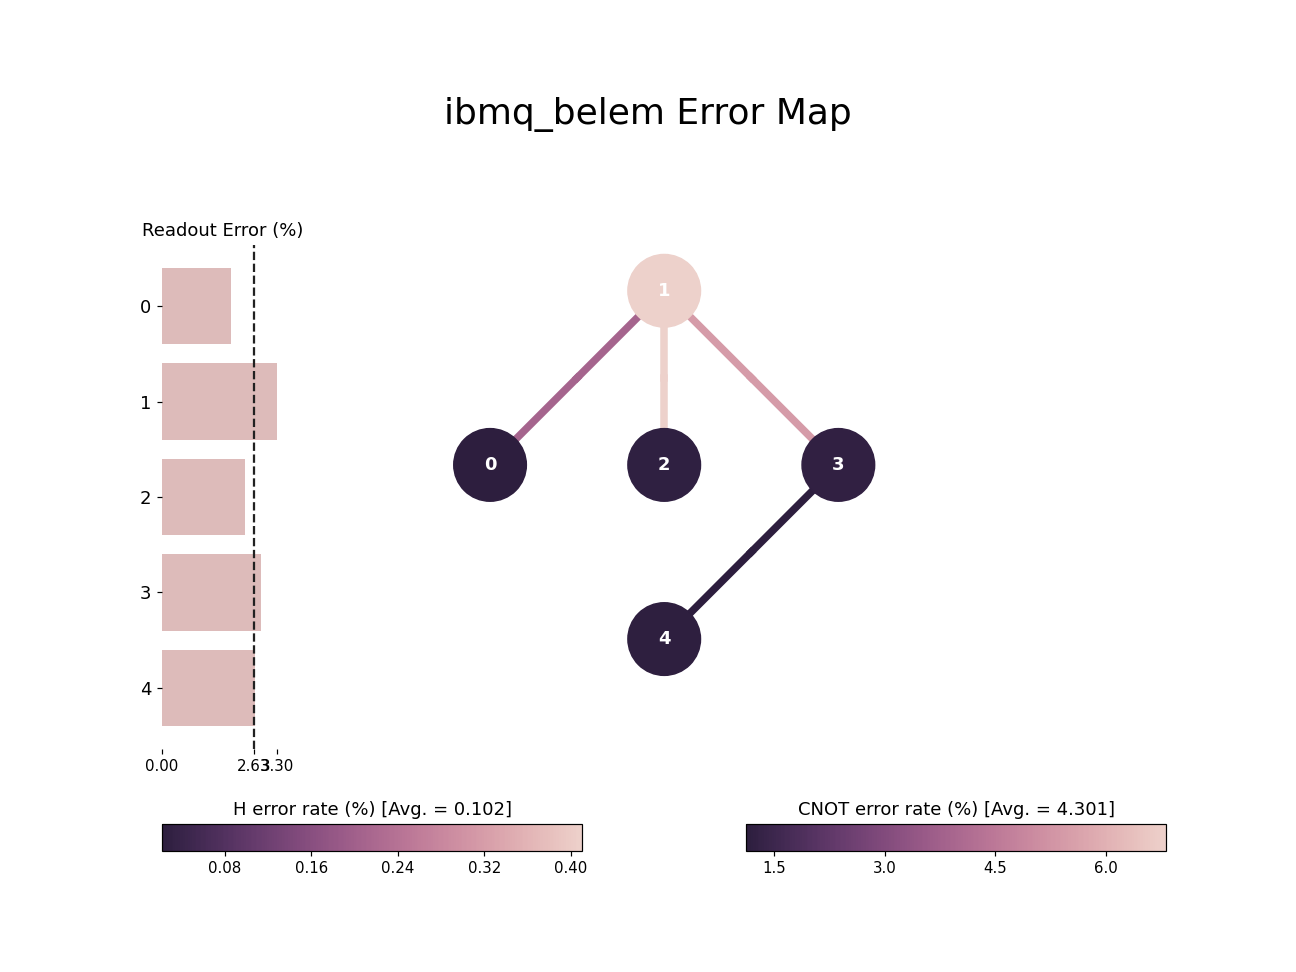

In [ ]:
# provider = IBMQ.load_account()
# backend = provider.get_backend('ibmq_belem')
# qiskit.visualization.plot_error_map(backend)

In [ ]:
# if you want to get job
# job = backend.retrieve_job('628dc37f3bb6a94bdd7c21db')


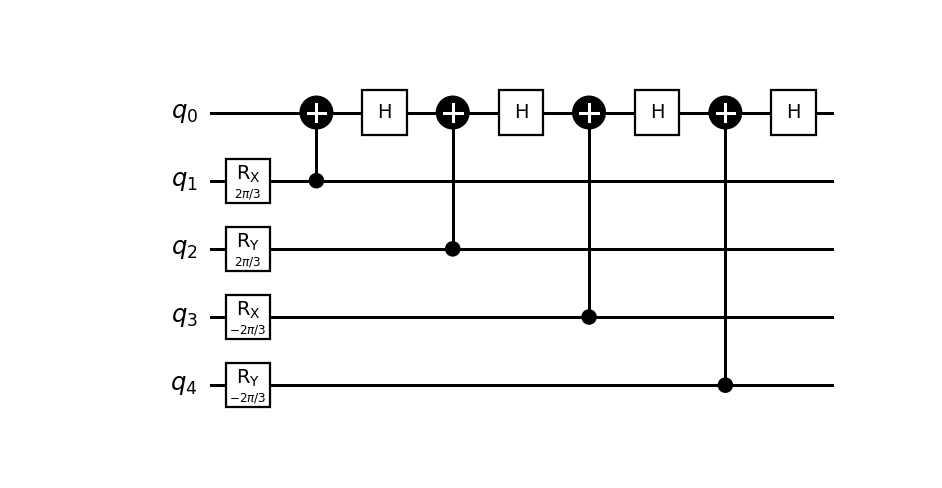

In [ ]:
qreg_q = QuantumRegister(5, 'q')
circuit = QuantumCircuit(qreg_q)

# circuit.h(qreg_q[1])
# circuit.cx(qreg_q[1], qreg_q[2])
# circuit.cx(qreg_q[1], qreg_q[3])
# circuit.cx(qreg_q[1], qreg_q[4])
# circuit.cx(qreg_q[0], qreg_q[1])
# circuit.cx(qreg_q[0], qreg_q[2])
# circuit.cx(qreg_q[0], qreg_q[3])

# circuit.cx(qreg_q[3], qreg_q[4])
# circuit.cz(qreg_q[0], qreg_q[4])

circuit.rx(np.pi/1.5,qreg_q[1])
circuit.cx(qreg_q[1],qreg_q[0])
circuit.h(qreg_q[0])
circuit.ry(np.pi/1.5,qreg_q[2])
circuit.cx(qreg_q[2],qreg_q[0])
circuit.h(qreg_q[0])
circuit.rx(-np.pi/1.5,qreg_q[3])
circuit.cx(qreg_q[3],qreg_q[0])
circuit.h(qreg_q[0])
circuit.ry(-np.pi/1.5,qreg_q[4])
circuit.cx(qreg_q[4],qreg_q[0])
circuit.h(qreg_q[0])

circuit.draw('mpl',style='bw')

In [ ]:
# ch, job = ChannelFromProc(backend,circuit,input_job=job,measured = 4, prepeared = 0)

{(('Zp',), ('X',)): {'0': 2003, '1': 1997}, (('Zp',), ('Y',)): {'0': 2024, '1': 1976}, (('Zp',), ('Z',)): {'0': 2321, '1': 1679}, (('Zm',), ('X',)): {'0': 2045, '1': 1955}, (('Zm',), ('Y',)): {'0': 2085, '1': 1915}, (('Zm',), ('Z',)): {'0': 1699, '1': 2301}, (('Xp',), ('X',)): {'0': 2170, '1': 1830}, (('Xp',), ('Y',)): {'0': 1791, '1': 2209}, (('Xp',), ('Z',)): {'0': 2039, '1': 1961}, (('Yp',), ('X',)): {'0': 1755, '1': 2245}, (('Yp',), ('Y',)): {'0': 2115, '1': 1885}, (('Yp',), ('Z',)): {'0': 2156, '1': 1844}}
Fit time: 0.005999088287353516
Average gate fidelity: F = 0.54312


In [ ]:
backend = Aer.get_backend('qasm_simulator')

In [ ]:
ch, job = ChannelFromProc(backend,circuit,noise_model=noise_model,measured = 0, prepeared = 0)
TransSphereFromChannel(ch)

{(('Zp',), ('X',)): {'1': 1978, '0': 2022}, (('Zp',), ('Y',)): {'1': 2030, '0': 1970}, (('Zp',), ('Z',)): {'0': 2508, '1': 1492}, (('Zm',), ('X',)): {'0': 2059, '1': 1941}, (('Zm',), ('Y',)): {'1': 2066, '0': 1934}, (('Zm',), ('Z',)): {'1': 2504, '0': 1496}, (('Xp',), ('X',)): {'0': 2501, '1': 1499}, (('Xp',), ('Y',)): {'1': 2037, '0': 1963}, (('Xp',), ('Z',)): {'0': 1976, '1': 2024}, (('Yp',), ('X',)): {'0': 2018, '1': 1982}, (('Yp',), ('Y',)): {'1': 1899, '0': 2101}, (('Yp',), ('Z',)): {'0': 2011, '1': 1989}}
Fit time: 0.005484342575073242
Average gate fidelity: F = 0.59296




{(('Zp',), ('X',)): {'0': 2015, '1': 1985}, (('Zp',), ('Y',)): {'1': 2051, '0': 1949}, (('Zp',), ('Z',)): {'0': 1002, '1': 2998}, (('Zm',), ('X',)): {'1': 2013, '0': 1987}, (('Zm',), ('Y',)): {'0': 2002, '1': 1998}, (('Zm',), ('Z',)): {'0': 3015, '1': 985}, (('Xp',), ('X',)): {'1': 3006, '0': 994}, (('Xp',), ('Y',)): {'1': 1982, '0': 2018}, (('Xp',), ('Z',)): {'1': 2011, '0': 1989}, (('Yp',), ('X',)): {'1': 2057, '0': 1943}, (('Yp',), ('Y',)): {'0': 2525, '1': 1475}, (('Yp',), ('Z',)): {'1': 1991, '0': 2009}}
Fit time: 0.007912397384643555
Average gate fidelity: F = 0.37800





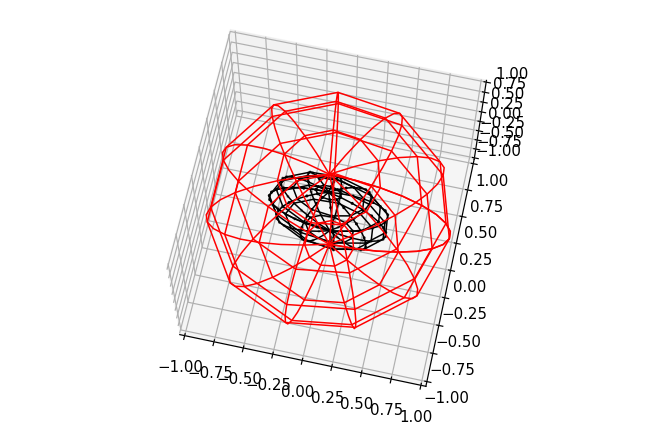

In [ ]:
ch, job = ChannelFromProc(backend,circuit,noise_model=noise_model,measured = 0, prepeared = 0)
TransSphereFromChannel(ch)

In [ ]:
noise_model = noise.NoiseModel()

In [ ]:
for qubit in range(2):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
    noise_model.add_readout_error(read_err,[qubit])

In [ ]:
# Параметры ошибки деполяризации
# Вероятности ошибки
prob_1gate = 0.1  # Однокубитный гейт
prob_2gate = 0.1   # Двухкубитный гейт
phase_1gate = 0.1
# Ошибки деполяризации
error_1 = noise.depolarizing_error(prob_1gate, 1)
error_2 = noise.depolarizing_error(prob_2gate, 2)
dephase = noise.phase_damping_error(phase_1gate)
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
# noise_model.add_all_qubit_quantum_error(dephase,['x','h','z','u1','u2','u3'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'u3', 'cx']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


In [ ]:
pref_circ = QuantumRegister(5, 'q')
pref_circ = QuantumCircuit(qreg_q)
pref_circ.initialize([1,0], 0)
prep_circ = pref_circ.compose(circuit)


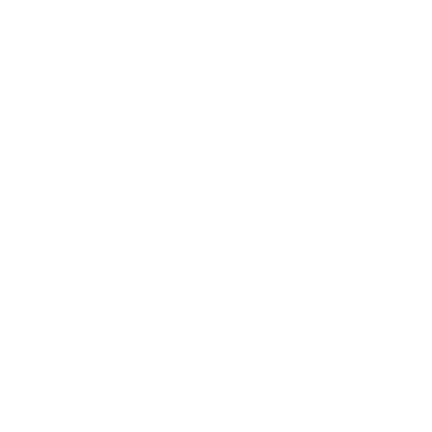

In [ ]:
test_rho,_ = Final_State_Tomography(backend,prep_circ, measured=4)
# print("Fidelity with real state:",qi.state_fidelity(test_rho.data,rho_exp.data))
qiskit.visualization.array_to_latex(test_rho.data)


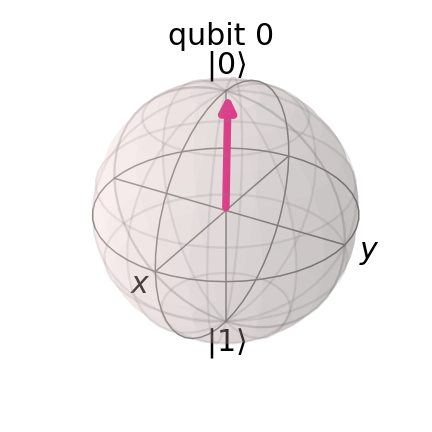

In [ ]:
plot_bloch_multivector(test_rho)

In [ ]:
in_States = [[1,0],[0,1],[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)],[1/np.sqrt(2),1j/np.sqrt(2)],[1/np.sqrt(2),-1j/np.sqrt(2)]]

In [ ]:
ch.outvec([1/np.sqrt(2),1/np.sqrt(2)])

DensityMatrix([[0.50823874+0.j        , 0.49924118-0.01397985j],
               [0.49924118+0.01397985j, 0.49176126+0.j        ]],
              dims=(2,))



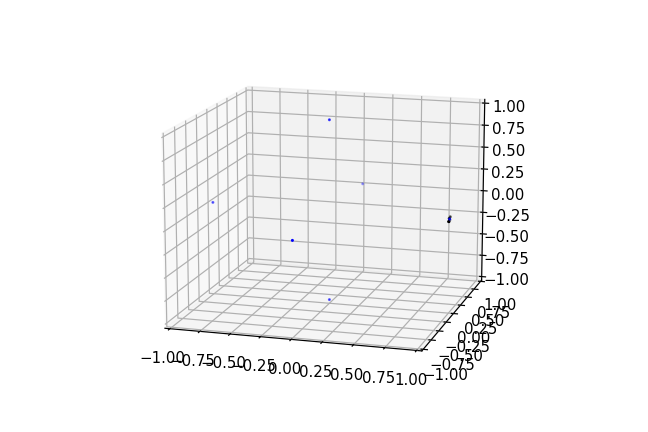

In [ ]:
TransSphereFromChannel(ch,in_States)
# GHZ belem system

{(('Zp',), ('X',)): {'1': 1976, '0': 2024}, (('Zp',), ('Y',)): {'1': 2075, '0': 1925}, (('Zp',), ('Z',)): {'0': 3048, '1': 952}, (('Zm',), ('X',)): {'0': 1956, '1': 2044}, (('Zm',), ('Y',)): {'1': 1969, '0': 2031}, (('Zm',), ('Z',)): {'1': 2974, '0': 1026}, (('Xp',), ('X',)): {'0': 2902, '1': 1098}, (('Xp',), ('Y',)): {'0': 1985, '1': 2015}, (('Xp',), ('Z',)): {'1': 1954, '0': 2046}, (('Yp',), ('X',)): {'1': 1961, '0': 2039}, (('Yp',), ('Y',)): {'0': 2761, '1': 1239}, (('Yp',), ('Z',)): {'0': 1948, '1': 2052}}
Fit time: 0.0030035972595214844
Average gate fidelity: F = 0.72550





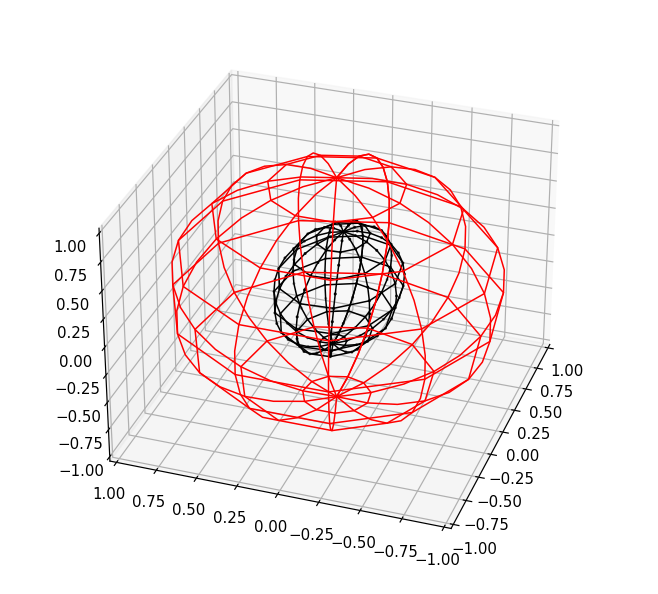

In [ ]:
noise_model = noise.NoiseModel()
# for qubit in range(2):
#     read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
#     noise_model.add_readout_error(read_err,[qubit])
# Параметры ошибки деполяризации
# Вероятности ошибки
prob_1gate = 0.1  # Однокубитный гейт
prob_2gate = 0.1   # Двухкубитный гейт
phase_1gate = 0.
# Ошибки деполяризации
error_1 = noise.depolarizing_error(prob_1gate, 1)
error_2 = noise.depolarizing_error(prob_2gate, 2)
dephase = noise.phase_damping_error(phase_1gate)
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
noise_model.add_all_qubit_quantum_error(dephase,['x','h','z'])
ch, job = ChannelFromProc(backend,circuit,noise_model=noise_model,measured = 4, prepeared = 0)
TransSphereFromChannel(ch)